In [31]:
from fastai import *
from fastai.vision.all import *

In [32]:
import os
from pathlib import Path
path=os.getcwd()
path=Path(path)
path=path/'data'
path

Path('e:/70 Days 70 Project/Face Mask Detection/data')

In [33]:
import numpy as np
np.random.seed(40)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=40),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(path, bs=32)

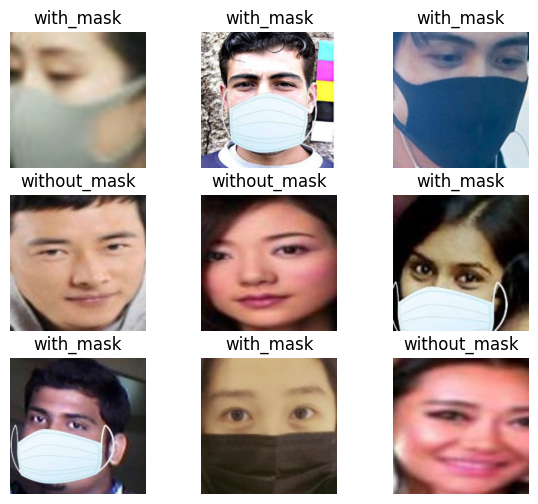

In [34]:
dls.show_batch(max_n=9, figsize=(7,6))

In [35]:
dls.c

2

In [36]:
from torchvision.models import resnet152
learn=vision_learner(dls, resnet152, metrics=accuracy)
learn.freeze()

In [37]:
learn.freeze_to(-5)

In [ ]:
learn.fine_tune(10, base_lr=1e-3)

In [ ]:
learn.show_results()

In [ ]:
learn.save("facemask_resnet")

Accuracy 0.998676

# Method Pytorch

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from PIL import Image
import os

In [40]:
file_paths=[]
labels=[]
for label in os.listdir(path):
    for file in os.listdir(path/label):
        file_paths.append(path/label/file)
        labels.append(label)

In [41]:
file_paths[:10],labels[:10]

([Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_10.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_100.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1000.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1001.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1002.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1003.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1004.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1005.jpg'),
  Path('e:/70 Days 70 Project/Face Mask Detection/data/without_mask/without_mask_1006.jpg')],
 ['without_mask',
  'without_mask',
  'without_mask',
  'without_mask',
  '

In [42]:
class FaceMaskDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        # Create label mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')  # Convert to RGB
        label = self.labels[idx]
        label = self.label_to_idx[label]  # Convert string label to integer
        if self.transform:
            image = self.transform(image)
        return image, label

In [43]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])


In [44]:
dataset=FaceMaskDataset(file_paths, labels, transform=transform)
dataloader=DataLoader(dataset, batch_size=32, shuffle=True)


In [45]:
class FaceMaskCNN(nn.Module):
    def  __init__(self, num_classes):
        super(FaceMaskCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [46]:
model=FaceMaskCNN(num_classes=2)
model

FaceMaskCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

In [ ]:
from tqdm import tqdm

epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [ ]:
torch.save(model.state_dict(), 'facemask_cnn.pth')